In [1]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print(f"GPU is available. Using {torch.cuda.get_device_name(0)}.")
else:
    device = torch.device("cpu")   # Use CPU
    print("GPU is not available. Using CPU.")

# Example: Moving a tensor or model to the device (GPU or CPU)
# tensor = torch.tensor([1, 2, 3]).to(device)
# model = model.to(device)  # If you have a model

# Example tensor to verify it's on the correct device
tensor = torch.tensor([1, 2, 3], device=device)
print(f"Tensor is on: {tensor.device}")


GPU is available. Using NVIDIA GeForce RTX 3070 Ti Laptop GPU.
Tensor is on: cuda:0


In [2]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Number of labels for multilabel classification (set this based on your task)
num_classes = 4 

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load pre-trained DistilBERT model for multilabel classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)
model.config.problem_type = "multi_label_classification"  # Set the problem type

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print confirmation
print(f'Model is loaded with {num_classes} output classes and using device: {device}')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model is loaded with 4 output classes and using device: cuda


In [3]:
import pandas as pd

# Read the Excel file
file_path = 'Df_manual by AMC_v2.xlsx'
df = pd.read_excel(file_path)

# Define the list of possible output labels
output_labels = ['Delivery', 'Product Quality', 'Price', 'Customer Service']

# Function to extract labels from the 'Aspect 1', 'Aspect 2', 'Aspect 3' columns
def extract_labels(row):
    labels = []
    for aspect in ['Aspect 1', 'Aspect 2', 'Aspect 3']:
        if row[aspect] in output_labels:
            labels.append(row[aspect])
    return labels

# Create a new column with the list of output labels
df['Output Labels'] = df.apply(extract_labels, axis=1)

# Display the first few rows to check the result
print(df[['Combined Text', 'Aspect 1', 'Aspect 2', 'Aspect 3', 'Output Labels']].head())


                                       Combined Text  Aspect 1  \
0  Best price for good ink cartridge. Easy to ins...     Price   
1                             Order came very quick!  Delivery   
2  Been using this ink for years and even though ...     Price   
3        Good but expensive but this is Biden' fault     Price   
4   Great price and delivery right to my front door!     Price   

          Aspect 2 Aspect 3             Output Labels  
0  Product Quality      NaN  [Price, Product Quality]  
1              NaN      NaN                [Delivery]  
2              NaN      NaN                   [Price]  
3  Product Quality      NaN  [Price, Product Quality]  
4         Delivery      NaN         [Price, Delivery]  


In [4]:
# Convert 'Output Labels' into binary vectors
def labels_to_vector(row):
    label_vector = [1 if label in row['Output Labels'] else 0 for label in output_labels]
    return label_vector

df['Label Vectors'] = df.apply(labels_to_vector, axis=1)

# Prepare text data and labels for the model
texts = df['Combined Text'].tolist()
labels = df['Label Vectors'].tolist()

# Tokenize the text data using DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

# Convert labels to torch tensors
labels = torch.tensor(labels)

# Create the dataset with the original DataFrame
class MultilabelDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, original_df):
        self.encodings = encodings
        self.labels = labels
        self.original_df = original_df

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
dataset = MultilabelDataset(encodings, labels, df)

# Displaying the first few rows for validation
print(df[['Combined Text', 'Aspect 1', 'Aspect 2', 'Aspect 3', 'Output Labels', 'Label Vectors']].head())

                                       Combined Text  Aspect 1  \
0  Best price for good ink cartridge. Easy to ins...     Price   
1                             Order came very quick!  Delivery   
2  Been using this ink for years and even though ...     Price   
3        Good but expensive but this is Biden' fault     Price   
4   Great price and delivery right to my front door!     Price   

          Aspect 2 Aspect 3             Output Labels Label Vectors  
0  Product Quality      NaN  [Price, Product Quality]  [0, 1, 1, 0]  
1              NaN      NaN                [Delivery]  [1, 0, 0, 0]  
2              NaN      NaN                   [Price]  [0, 0, 1, 0]  
3  Product Quality      NaN  [Price, Product Quality]  [0, 1, 1, 0]  
4         Delivery      NaN         [Price, Delivery]  [1, 0, 1, 0]  


In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, random_split
from torch.nn import BCEWithLogitsLoss

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Training Loss: 0.5027
Training Accuracy: 0.2508
Label 'Delivery' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.7676
Label 'Product Quality' - Precision: 0.4556, Recall: 0.2628, Accuracy: 0.4985
Label 'Price' - Precision: 0.8475, Recall: 0.8993, Accuracy: 0.7768
Label 'Instant ink' - Precision: 0.2000, Recall: 0.0513, Accuracy: 0.8624
Label 'Others' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.9908
Validation Accuracy: 0.4634
Label 'Delivery' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.7439
Label 'Product Quality' - Precision: 0.6304, Recall: 0.8529, Accuracy: 0.7317
Label 'Price' - Precision: 0.7927, Recall: 1.0000, Accuracy: 0.7927
Label 'Instant ink' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.8659
Label 'Others' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.9878


C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/3, Training Loss: 0.3708
Training Accuracy: 0.4434
Label 'Delivery' - Precision: 0.9474, Recall: 0.2368, Accuracy: 0.8196
Label 'Product Quality' - Precision: 0.6328, Recall: 0.7179, Accuracy: 0.6667
Label 'Price' - Precision: 0.8576, Recall: 0.9964, Accuracy: 0.8563
Label 'Instant ink' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.8807
Label 'Others' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.9908
Validation Accuracy: 0.5854
Label 'Delivery' - Precision: 0.8500, Recall: 0.8095, Accuracy: 0.9146
Label 'Product Quality' - Precision: 0.6750, Recall: 0.7941, Accuracy: 0.7561
Label 'Price' - Precision: 0.9545, Recall: 0.9692, Accuracy: 0.9390
Label 'Instant ink' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.8659
Label 'Others' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.9878


C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/3, Training Loss: 0.2760
Training Accuracy: 0.6177
Label 'Delivery' - Precision: 0.8413, Recall: 0.6974, Accuracy: 0.8991
Label 'Product Quality' - Precision: 0.8613, Recall: 0.7564, Accuracy: 0.8257
Label 'Price' - Precision: 0.9609, Recall: 0.9712, Accuracy: 0.9419
Label 'Instant ink' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.8807
Label 'Others' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.9908
Validation Accuracy: 0.6585
Label 'Delivery' - Precision: 0.9333, Recall: 0.6667, Accuracy: 0.9024
Label 'Product Quality' - Precision: 0.8966, Recall: 0.7647, Accuracy: 0.8659
Label 'Price' - Precision: 0.8904, Recall: 1.0000, Accuracy: 0.9024
Label 'Instant ink' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.8659
Label 'Others' - Precision: 0.0000, Recall: 0.0000, Accuracy: 0.9878


C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Accuracy: 0.6585
Label 'Delivery' - Precision: 0.9333, Recall: 0.6667
Label 'Product Quality' - Precision: 0.8966, Recall: 0.7647
Label 'Price' - Precision: 0.8904, Recall: 1.0000
Label 'Instant ink' - Precision: 0.0000, Recall: 0.0000
Label 'Others' - Precision: 0.0000, Recall: 0.0000


C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


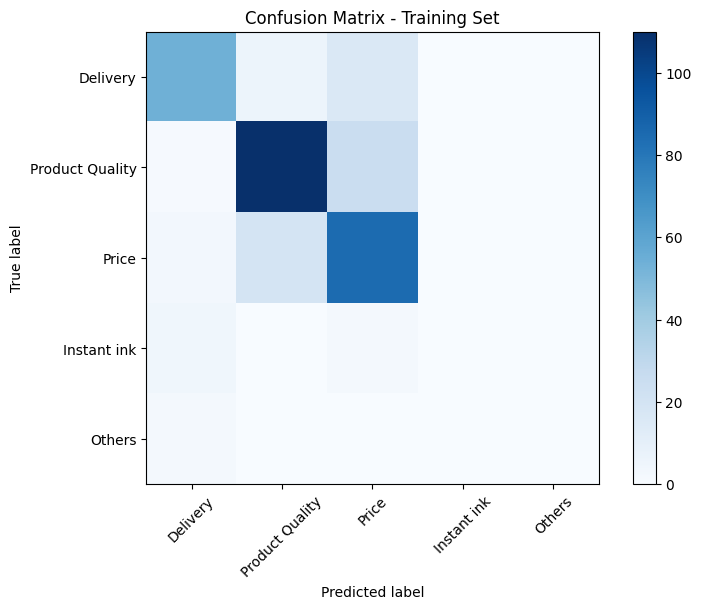

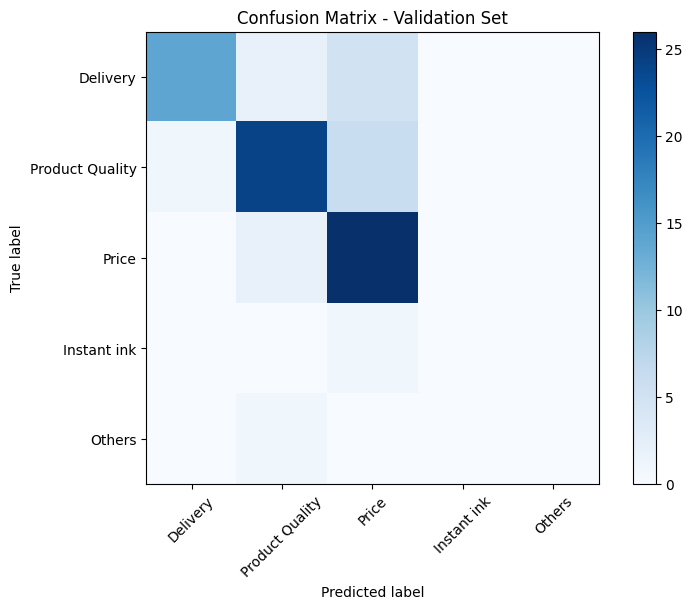

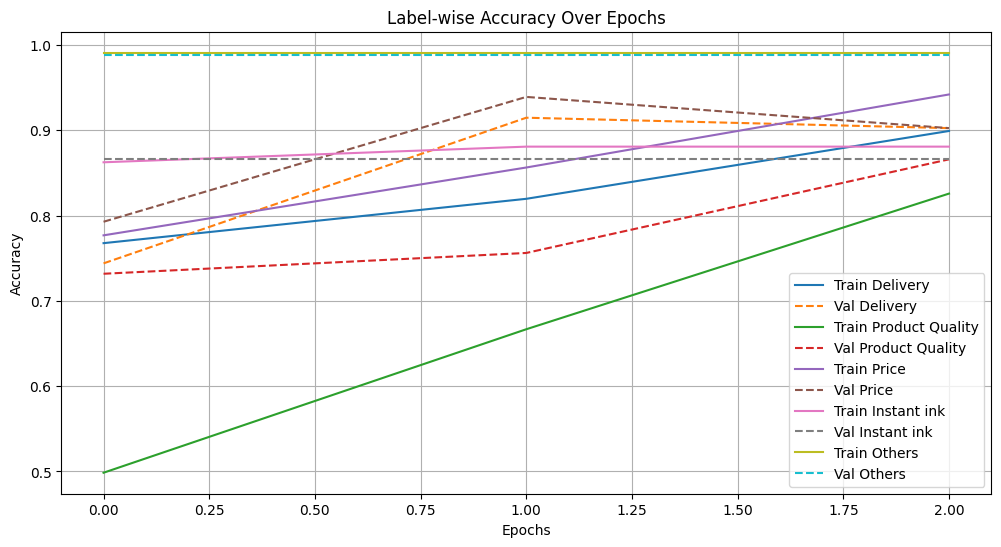

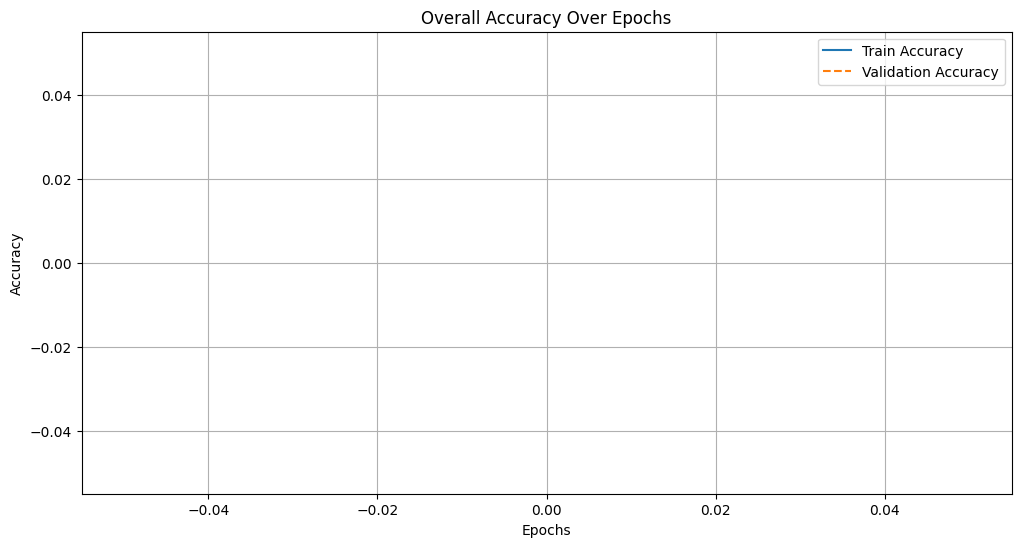

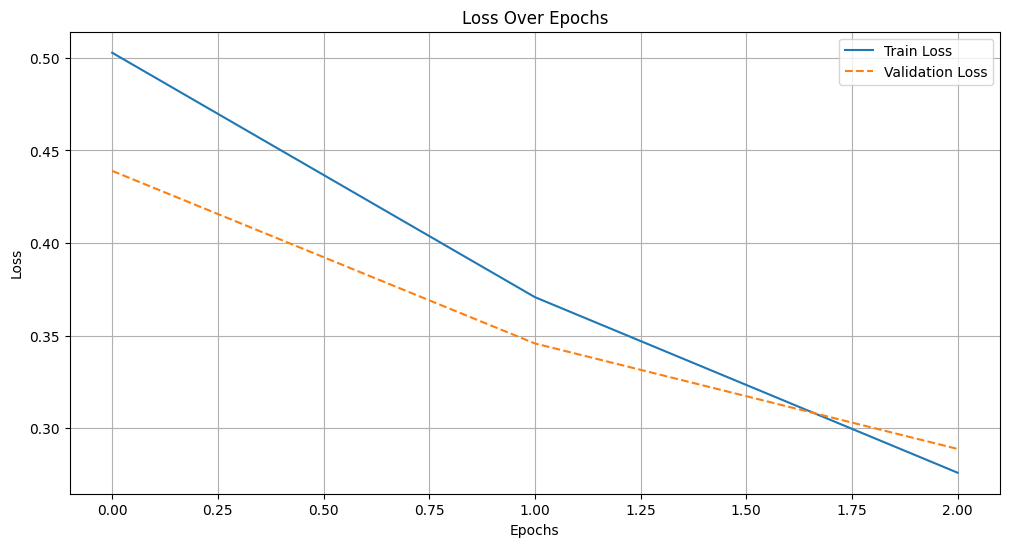

In [27]:
# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained DistilBERT model for multilabel classification (number of classes = 5)
num_classes = len(output_labels)  # 5 labels including 'Others'
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Initialize lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_label_accuracies = [[] for _ in output_labels]
val_label_accuracies = [[] for _ in output_labels]

# List to store metrics
metrics_list = []

# Store predictions and true labels for final prediction
final_predictions = []
final_true_labels = []

# Training loop
epochs = 3  
for epoch in range(epochs):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []

    for batch in train_loader:
        # Move batch data to GPU if available
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)  # Ensure labels are floats for BCE loss

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)

        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store predictions and true labels for metrics calculation
        predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
        true_labels.append(labels.cpu().numpy())

    # Calculate average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_loss:.4f}")

    # Calculate evaluation metrics after each epoch
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    # Binarize predictions using a threshold (0.5)
    binary_predictions = (predictions > 0.5).astype(int)

    # Calculate accuracy, precision, recall, and F1 score for training
    accuracy = accuracy_score(true_labels, binary_predictions)
    precision = precision_score(true_labels, binary_predictions, average=None)
    recall = recall_score(true_labels, binary_predictions, average=None)

    # Store metrics for training
    train_metrics = {
        'Epoch': epoch + 1,
        'Phase': 'Train',
        'Loss': avg_loss,
        'Accuracy': accuracy
    }

    # Store precision, recall, and label accuracy
    for i, label in enumerate(output_labels):
        label_accuracy = accuracy_score(true_labels[:, i], binary_predictions[:, i])
        train_metrics[f'Precision_{label}'] = precision[i]
        train_metrics[f'Recall_{label}'] = recall[i]
        train_metrics[f'Accuracy_{label}'] = label_accuracy
        train_label_accuracies[i].append(label_accuracy)

    metrics_list.append(train_metrics)

    # Print metrics for the current epoch
    print(f"Training Accuracy: {accuracy:.4f}")
    for i, label in enumerate(output_labels):
        print(f"Label '{label}' - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, Accuracy: {train_label_accuracies[i][-1]:.4f}")

    # Validation phase
    model.eval()
    val_total_loss = 0
    val_predictions, val_true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            val_loss = loss_fct(logits, labels)
            val_total_loss += val_loss.item()

            val_predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            val_true_labels.append(labels.cpu().numpy())

    # Calculate average loss for validation
    avg_val_loss = val_total_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Concatenate results for metrics
    val_predictions = np.concatenate(val_predictions, axis=0)
    val_true_labels = np.concatenate(val_true_labels, axis=0)
    binary_val_predictions = (val_predictions > 0.5).astype(int)

    # Calculate metrics for validation
    val_accuracy = accuracy_score(val_true_labels, binary_val_predictions)
    val_precision = precision_score(val_true_labels, binary_val_predictions, average=None)
    val_recall = recall_score(val_true_labels, binary_val_predictions, average=None)

    # Store metrics for validation
    val_metrics = {
        'Epoch': epoch + 1,
        'Phase': 'Validation',
        'Loss': avg_val_loss,
        'Accuracy': val_accuracy
    }

    # Store precision, recall, and label accuracy for validation
    for i, label in enumerate(output_labels):
        label_accuracy = accuracy_score(val_true_labels[:, i], binary_val_predictions[:, i])
        val_metrics[f'Precision_{label}'] = val_precision[i]
        val_metrics[f'Recall_{label}'] = val_recall[i]
        val_metrics[f'Accuracy_{label}'] = label_accuracy
        val_label_accuracies[i].append(label_accuracy)

    metrics_list.append(val_metrics)

    # Print metrics for the current epoch
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    for i, label in enumerate(output_labels):
        print(f"Label '{label}' - Precision: {val_precision[i]:.4f}, Recall: {val_recall[i]:.4f}, Accuracy: {val_label_accuracies[i][-1]:.4f}")

# Call evaluation after training
val_accuracy, val_precision, val_recall, confusion_mat = evaluate_model(model, val_loader)

# Print validation metrics
print(f"Validation Accuracy: {val_accuracy:.4f}")
for i, label in enumerate(output_labels):
    print(f"Label '{label}' - Precision: {val_precision[i]:.4f}, Recall: {val_recall[i]:.4f}")

# Optionally plot the confusion matrix for training
train_confusion_mat = confusion_matrix(true_labels.argmax(axis=1), binary_predictions.argmax(axis=1))

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(output_labels))
    plt.xticks(tick_marks, output_labels, rotation=45)
    plt.yticks(tick_marks, output_labels)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(train_confusion_mat, 'Confusion Matrix - Training Set')
plot_confusion_matrix(confusion_mat, 'Confusion Matrix - Validation Set')

# Plot accuracy for each label
plt.figure(figsize=(12, 6))
for i, label in enumerate(output_labels):
    plt.plot(train_label_accuracies[i], label=f'Train {label}')
    plt.plot(val_label_accuracies[i], label=f'Val {label}', linestyle='--')

plt.title('Label-wise Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot overall accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--')

plt.title('Overall Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')

plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Create a DataFrame to store predictions
predictions_df = pd.DataFrame({
    'True Labels': val_true_labels.tolist(),
    'Predictions': val_predictions.tolist()
})

# Save predictions to Excel
predictions_df.to_excel('predictions.xlsx', index=False)

# Save training metrics to Excel
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_excel('training_metrics.xlsx', index=False)

In [ ]:
# Convert dataset to DataFrame for predictions (adjust according to your dataset structure)
data = []
for i in range(len(dataset)):
    data_item = dataset[i]
    data.append({
        'text': data_item['text'],  # Adjust based on how text is accessed in your dataset
        'labels': data_item['labels']  # Adjust if necessary
    })

# Convert list to DataFrame
results_df = pd.DataFrame(data)

In [25]:
# Save the metrics DataFrame to an Excel file
metrics_df.to_excel('training_validation_metrics.xlsx', index=False)

In [26]:
# Save the trained model and tokenizer
model_save_path = 'distilbert_multilabel_model.pth'
tokenizer_save_path = 'distilbert_tokenizer'

# Save the model state
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Save the tokenizer (if using Hugging Face's tokenizer)
model.save_pretrained(tokenizer_save_path)
print(f'Tokenizer saved to {tokenizer_save_path}')

# Optionally save the entire model with configuration for future use
model_with_config_save_path = 'distilbert_multilabel_model_with_config'
model.save_pretrained(model_with_config_save_path)
print(f'Model with configuration saved to {model_with_config_save_path}')

Model saved to distilbert_multilabel_model.pth
Tokenizer saved to distilbert_tokenizer
Model with configuration saved to distilbert_multilabel_model_with_config


## Updated using Multilabel metrics

In [5]:
import pandas as pd
import numpy as np
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, random_split
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, classification_report

# Assuming 'dataset' is your prepared dataset

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained DistilBERT model for multilabel classification (number of classes)
output_labels = ['Delivery', 'Product Quality', 'Price', 'Customer Service']  # Update based on your labels
num_classes = len(output_labels)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Initialize lists to store metrics
train_losses = []
val_losses = []
metrics_list = []

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    true_labels = []
    predictions = []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Correctly access the logits

        # Calculate loss
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        total_loss += loss.item()

        # Store true labels and predictions for metrics
        true_labels.append(labels.detach().cpu().numpy())
        predictions.append((torch.sigmoid(logits) > 0.5).detach().cpu().numpy())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Concatenate predictions and true labels for the training set
    true_labels_concat = np.concatenate(true_labels)
    predictions_concat = np.concatenate(predictions)

    # Validation phase
    model.eval()
    val_total_loss = 0
    val_true_labels = []
    val_predictions = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Correctly access the logits

            val_loss = loss_fct(logits, labels)
            val_total_loss += val_loss.item()

            # Store true labels and predictions for metrics
            val_true_labels.append(labels.detach().cpu().numpy())
            val_predictions.append((torch.sigmoid(logits) > 0.5).detach().cpu().numpy())

    # Calculate average loss for validation
    avg_val_loss = val_total_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Concatenate predictions and true labels for the validation set
    val_true_labels_concat = np.concatenate(val_true_labels)
    val_predictions_concat = np.concatenate(val_predictions)

    # Compute performance metrics (macro and micro) for validation
    f1_macro = f1_score(val_true_labels_concat, val_predictions_concat, average='macro')
    f1_micro = f1_score(val_true_labels_concat, val_predictions_concat, average='micro')
    precision_macro = precision_score(val_true_labels_concat, val_predictions_concat, average='macro')
    precision_micro = precision_score(val_true_labels_concat, val_predictions_concat, average='micro')
    recall_macro = recall_score(val_true_labels_concat, val_predictions_concat, average='macro')
    recall_micro = recall_score(val_true_labels_concat, val_predictions_concat, average='micro')
    hamming = hamming_loss(val_true_labels_concat, val_predictions_concat)

    # Log metrics for this epoch
    metrics_list.append({
        'Epoch': epoch + 1,
        'Train Loss': avg_loss,
        'Validation Loss': avg_val_loss,
        'F1 Score (Macro)': f1_macro,
        'F1 Score (Micro)': f1_micro,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Hamming Loss': hamming
    })

    # Generate classification reports for both training and validation
    print(f"\nEpoch {epoch + 1} Classification Report (Training):")
    print(classification_report(true_labels_concat, predictions_concat, target_names=output_labels))

    print(f"\nEpoch {epoch + 1} Classification Report (Validation):")
    print(classification_report(val_true_labels_concat, val_predictions_concat, target_names=output_labels))

# Save training metrics to Excel
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_excel('training_metrics_combined_v3.xlsx', index=False)

print("Training metrics saved to 'training_metrics_combined_v3.xlsx'")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\angme\AppData\Local\Temp\ipykernel_23692\470256379.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torc


Epoch 1 Classification Report (Training):
                  precision    recall  f1-score   support

        Delivery       0.00      0.00      0.00        73
 Product Quality       0.61      0.44      0.51       174
           Price       0.74      0.88      0.81       275
Customer Service       0.25      0.02      0.04        48

       micro avg       0.69      0.56      0.62       570
       macro avg       0.40      0.34      0.34       570
    weighted avg       0.56      0.56      0.55       570
     samples avg       0.62      0.55      0.56       570


Epoch 1 Classification Report (Validation):
                  precision    recall  f1-score   support

        Delivery       0.00      0.00      0.00        28
 Product Quality       0.60      0.74      0.67        43
           Price       0.81      0.99      0.89        73
Customer Service       0.00      0.00      0.00         7

       micro avg       0.73      0.69      0.71       151
       macro avg       0.35      0.43

C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:15


Epoch 3 Classification Report (Training):
                  precision    recall  f1-score   support

        Delivery       0.90      0.71      0.79        73
 Product Quality       0.84      0.82      0.83       174
           Price       0.99      0.98      0.98       275
Customer Service       0.88      0.94      0.91        48

       micro avg       0.92      0.89      0.91       570
       macro avg       0.90      0.86      0.88       570
    weighted avg       0.92      0.89      0.91       570
     samples avg       0.92      0.90      0.89       570


Epoch 3 Classification Report (Validation):
                  precision    recall  f1-score   support

        Delivery       1.00      0.57      0.73        28
 Product Quality       0.76      0.72      0.74        43
           Price       0.93      0.97      0.95        73
Customer Service       0.88      1.00      0.93         7

       micro avg       0.89      0.83      0.86       151
       macro avg       0.89      0.82

C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:15

In [6]:
print(metrics_df)


   Epoch  Train Loss  Validation Loss  F1 Score (Macro)  F1 Score (Micro)  \
0      1    0.552833         0.461517          0.388889          0.709898   
1      2    0.373071         0.315463          0.770039          0.819788   
2      3    0.235021         0.256960          0.837930          0.856164   

   Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  \
0           0.353191           0.732394        0.432622        0.688742   
1           0.888200           0.878788        0.742112        0.768212   
2           0.891327           0.886525        0.816240        0.827815   

   Hamming Loss  
0      0.230978  
1      0.138587  
2      0.114130  


In [7]:
# Save the tokenizer
tokenizer.save_pretrained('models/distilbert multilabels_v3')
print(f'Tokenizer saved to models/distilbert multilabels_v3')

# Save the entire model with configuration for future use
model.save_pretrained('models/distilbert multilabels_v3')
print(f'Model with configuration saved to models/distilbert multilabels_v3')


Tokenizer saved to models/distilbert multilabels_v3
Model with configuration saved to models/distilbert multilabels_v3


In [14]:
import os
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset  # Import Dataset

# Function to prepare dataset from text
def prepare_dataset(texts, tokenizer, max_length=512):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    return list(zip(encodings['input_ids'], encodings['attention_mask']))

# Custom dataset for batching
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings[idx][0],
            'attention_mask': self.encodings[idx][1]
        }

# Function to load model, predict, and update DataFrame
def predict_and_update_dataframe(model_path, df, text_column='Combined Text', output_labels=None, batch_size=16):
    # Load the tokenizer using relative paths
    try:
        tokenizer = DistilBertTokenizer.from_pretrained(model_path)
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return

    # Instantiate the model and load the weights
    try:
        model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=len(output_labels))
    except Exception as e:
        print(f"Error loading model or weights: {e}")
        return

    # Move model to device (use CPU if GPU is not available or out of memory)
    # device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    device = torch.device('cpu')
    model.to(device)
    model.eval()

    # Prepare the dataset from the DataFrame
    dataset = df[text_column].tolist()  # Assuming 'Combined Text' contains the text data
    encodings = prepare_dataset(dataset, tokenizer)

    # Use DataLoader to load data in batches
    data_loader = DataLoader(TextDataset(encodings), batch_size=batch_size, shuffle=False)

    predictions = []

    # Perform inference in batches
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.sigmoid(logits).cpu().numpy()

            # Convert predictions to label columns
            for pred in preds:
                labels = [output_labels[i] for i in range(len(output_labels)) if pred[i] >= 0.5]  # Threshold of 0.5
                predictions.append(labels)

    # Add predictions back to the DataFrame
    df['Predicted Labels'] = predictions

    # Save the updated DataFrame to an Excel file
    df.to_excel('predicted_labels_v2.xlsx', index=False)
    print('Predictions saved to predicted_labels_v2.xlsx')

model_path = 'models/distilbert multilabels_v2'
# Example usage
predict_and_update_dataframe(
    model_path,
    df,
    output_labels=['Delivery', 'Product Quality', 'Price', 'Instant ink', 'Customer Service'],
    batch_size=8  # Try reducing the batch size to 8 or lower if memory issue persists
)


Predictions saved to predicted_labels_v2.xlsx
